# Evaluación del Modelo Final

In [1]:
import feather
import pickle
from time import time

import numpy as np 
import pandas as pd

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

## Carga de datos
Cargamos los conjuntos de entrenamiento y prueba y separamos las variable objetivo.

In [2]:
walmart = feather.read_dataframe('feathers/walmart_wide_train(1).feather')

train = walmart.drop(['trip_type','visit_number'], axis=1)
y_train=walmart.iloc[:,1]

In [3]:
test = feather.read_dataframe('feathers/walmart_wide_test(1).feather')
test_visit_number = test.iloc[:,0]

In [4]:
# cargamos el pickle de variables seleccionadas
selected_var = pickle.load(open("pickles/selected_var","rb"))

In [5]:
train = train[selected_var]
test = test[selected_var]

In [6]:
print(train.shape, test.shape)

(95674, 50) (95674, 50)


## Entrenamiento
Una vez concluído el magic loop, se obtuvieron dos modelos con resultados similares de precisión, por lo que se decidió probar ambos para hacer dos submissions distintas.

### con SVM
Los mejores hiperparámetros seleccionados con el magic loop fueron:

+ **C** *(regularización)* : 0.1
+ **kernel** : lineal

Entrenando el modelo con estos parámetros:

In [17]:
%%time
model_svm = svm.SVC(C=0.1, kernel='linear', probability=True, random_state=0)
model_svm.fit(train, y_train)
y_model_svm = model_svm.predict(test)

CPU times: user 25min 48s, sys: 3.1 s, total: 25min 52s
Wall time: 25min 53s


Guardamos el modelo entrenado dentro de un pickle, ya que tarda un tiempo considerable en correr.

In [18]:
pickle.dump(model_svm, open("pickles/model_svm", "wb"))

Ahora, formateamos nuestras predicciones de manera que tengan la misma forma que el sample_submission proporcionado en la competencia.

In [228]:
prediction = pd.DataFrame(y_model_svm)
prediction.columns = ['TripType']

In [229]:
submission = pd.DataFrame(test_visit_number)
submission["TripType"] = pd.DataFrame(prediction)

In [230]:
submission_wide = submission.pivot(index='visit_number',columns='TripType', values='TripType')
submission_wide['4'] = 0
submission_wide['23'] = 0

In [231]:
colnames = list(submission_wide)
colnames = [int(i) for i in colnames]
colnames.sort()
colnames = [str(i) for i in colnames]

In [232]:
submission_wide = submission_wide[colnames].add_prefix('TripType_').reset_index()

In [233]:
VisitNumber = pd.DataFrame(submission_wide.iloc[:,0])
VisitNumber.columns = ['VisitNumber']

In [235]:
submission_wide=submission_wide.fillna(0)
submission_wide = submission_wide.apply(pd.to_numeric)

In [236]:
submission_wide = submission_wide.clip(upper=1)

In [237]:
submission_wide = submission_wide.drop('visit_number', axis=1)

In [238]:
#submission_wide = VisitNumber.append(submission_wide, ignore_index=True)
idx = 0  # can be a list, a Series, an array or a scalar   
submission_wide.insert(loc=idx, column='VisitNumber', value=VisitNumber)

Checamos el resultado final:

In [249]:
submission_wide

TripType,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95669,191338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
95671,191340,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Pasamos todos los valores a enteros, pues la competencia no acepta floats.

In [248]:
submission_wide = submission_wide.astype(int)

Y finalmente, escribimos nuestro archivo csv.

In [250]:
submission_wide.to_csv('submission_svm.csv', index=False)

## con Random Forest

Los mejores hiperparámetros seleccionados con el magic loop fueron:

+ **n_estimators** *(número de árboles)* : 500
+ **max_depth** *(tamaño máximo de cada árbol)* : 50
+ **max_features** *(máximo de variables a considerar en cada split)* : log2
+ **min_samples_split** *(mínimo de observaciones para hacer split)* : 10

Entrenando el modelo con estos parámetros:

In [7]:
%%time
model_rf = RandomForestClassifier(n_estimators=500, max_depth=50,
                                  max_features='log2', min_samples_split=10)
model_rf.fit(train, y_train)
y_model_rf = model_rf.predict(test)

CPU times: user 1min 11s, sys: 1.61 s, total: 1min 12s
Wall time: 1min 12s


Guardamos el modelo en un pickle.

In [8]:
pickle.dump(model_rf, open("pickles/model_rf", "wb"))

Como antes, formateamos la tabla para hacer la submission.

In [11]:
prediction_rf = pd.DataFrame(y_model_rf)
prediction_rf.columns = ['TripType']

In [14]:
submission = pd.DataFrame(test_visit_number)
submission["TripType"] = pd.DataFrame(prediction_rf)

In [48]:
submission_wide = submission.pivot(index='visit_number',columns='TripType', values='TripType')
submission_wide['14'] = 0
submission_wide['23'] = 0

In [49]:
colnames = list(submission_wide)
colnames = [int(i) for i in colnames]
colnames.sort()
colnames = [str(i) for i in colnames]

In [50]:
submission_wide = submission_wide[colnames].add_prefix('TripType_').reset_index()

In [51]:
VisitNumber = pd.DataFrame(submission_wide.iloc[:,0])
VisitNumber.columns = ['VisitNumber']

In [52]:
submission_wide=submission_wide.fillna(0)
submission_wide = submission_wide.apply(pd.to_numeric)
submission_wide = submission_wide.clip(upper=1)

In [53]:
submission_wide = submission_wide.drop('visit_number', axis=1)
idx = 0   
submission_wide.insert(loc=idx, column='VisitNumber', value=VisitNumber)

Y escribimos el archivo csv.

In [55]:
submission_wide = submission_wide.astype(int)
submission_wide.to_csv('submission_randomf.csv', index=False)

## Score Final en Kaggle

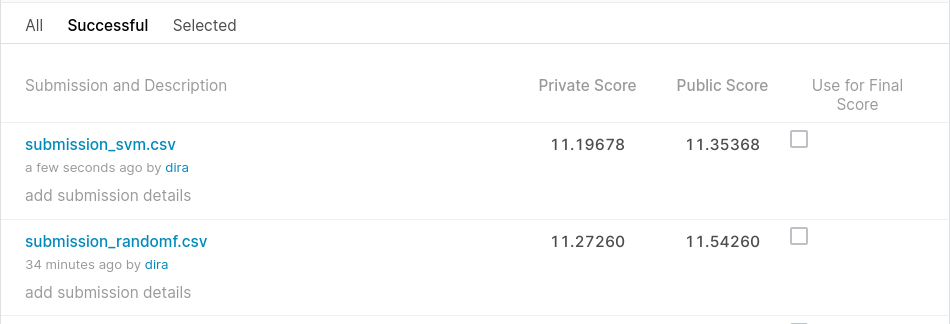

In [5]:
from IPython.display import Image
Image("imagenes/scores_kaggle.png")

Y notamos que SVM sigue superando a Random Forest.